##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Keras를 사용한 반복적 인 신경망 (RNN)

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/keras/rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/keras/rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/keras/rnn.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">    GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/keras/rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

## 시작하기

RNN (Recurrent Neural Network)은 시계열 또는 자연어와 같은 시퀀스 데이터를 모델링하는 데 강력한 신경망 클래스입니다.

도식적으로, RNN 계층은 `for` 루프를 사용하여 시퀀스의 시간 단계를 반복하고, 지금까지 본 시간 단계에 대한 정보를 인코딩하는 내부 상태를 유지합니다.

Keras RNN API는 다음에 중점을두고 설계되었습니다.

- **사용 편리성**: 내장 `keras.layers.RNN`, `keras.layers.LSTM`, `keras.layers.GRU` 레이어를 사용하여 어려운 구성 선택 없이도 반복 모델을 빠르게 구축할 수 있습니다.

- **사용자 정의 용이성** : 사용자 정의 동작으로 자체 RNN 셀 계층 ( `for` 루프의 내부 부분)을 정의하고 일반 `keras.layers.RNN` 계층 ( `for` 루프 자체)과 함께 사용할 수 있습니다. 이를 통해 최소한의 코드로 다양한 연구 아이디어를 유연한 방식으로 신속하게 프로토 타이핑 할 수 있습니다.

## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-12-14 22:16:29.308520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:16:29.308626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:16:29.308635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 내장 RNN 레이어: 간단한 예

Keras에는 세 개의 내장 RNN 레이어가 있습니다.

1. `keras.layers.SimpleRNN`: 이전 타임스텝의 출력이 다음 타임스텝으로 공급되는 완전히 연결된 RNN입니다.

2. `keras.layers.GRU`: [Cho 등(2014년)](https://arxiv.org/abs/1406.1078)에 의해 처음 제안되었습니다.

3. `keras.layers.LSTM`: [Hochreiter 및 Schmidhuber(1997년)](https://www.bioinf.jku.at/publications/older/2604.pdf)에 의해 처음 제안되었습니다.

2015년 초, LSTM 및 GRU의 재사용 가능한 오픈 소스 Python 구현이 Keras에 처음 이루어졌습니다.

다음은 정수 시퀀스를 처리하고 각 정수를 64차원 벡터에 포함시킨 다음 `LSTM` 레이어를 사용하여 벡터 시퀀스를 처리하는 `Sequential` 모델의 간단한 예입니다.

In [3]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 64)          64000     


 lstm (LSTM)                 (None, 128)               98816     


 dense (Dense)               (None, 10)                1290      


Total params: 164,106


Trainable params: 164,106


Non-trainable params: 0


_________________________________________________________________


내장 RNN은 여러 유용한 기능을 지원합니다.

- `dropout` 및 `recurrent_dropout` 인수를 통한 반복 드롭아웃
- `go_backwards` 인수를 통해 입력 시퀀스를 반대로 처리할 수 있음
- `unroll` 인수를 통한 루프 언롤링(CPU에서 짧은 시퀀스를 처리할 때 속도가 크게 향상될 수 있음)
- 기타 등등

자세한 내용은 [RNN API 설명서](https://keras.io/api/layers/recurrent_layers/)를 참조하세요.

## 출력과 상태

기본적으로, RNN 레이어의 출력에는 샘플당 하나의 벡터가 포함됩니다. 이 벡터는 마지막 타임스텝에 해당하는 RNN 셀 출력으로, 전체 입력 시퀀스에 대한 정보를 포함합니다. 이 출력의 형상은 `(batch_size, units)`이고, 여기서 `units`는 레이어의 생성자에 전달된 `units` 인수에 해당합니다.

`return_sequences=True`를 설정하면 RNN 레이어가 각 샘플(샘플 및 타임스텝당 하나의 벡터)에 대한 전체 출력 시퀀스도 반환할 수 있습니다. 이 출력의 형상은 `(batch_size, timesteps, units)`입니다.

In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, None, 64)          64000     


 gru (GRU)                   (None, None, 256)         247296    


 simple_rnn (SimpleRNN)      (None, 128)               49280     


 dense_1 (Dense)             (None, 10)                1290      


Total params: 361,866


Trainable params: 361,866


Non-trainable params: 0


_________________________________________________________________


또한 RNN 레이어는 최종 내부 상태를 반환할 수 있습니다. 반환된 상태는 나중에 RNN 실행을 재개하거나 [다른 RNN을 초기화](https://arxiv.org/abs/1409.3215)하는 데 사용될 수 있습니다. 이 설정은 인코더의 최종 상태가 디코더의 초기 상태로 사용되는 인코더-디코더 시퀀스-시퀀스 모델에서 일반적으로 사용됩니다.

내부 상태를 반환하도록 RNN 레이어를 구성하려면 레이어를 생성할 때 `return_state` 매개 변수를 `True` 설정합니다. 참고로 `LSTM`에는 두 개의 상태 텐서가 있지만 `GRU`에는 하나만 있습니다.

레이어의 초기 상태를 구성하려면 추가 키워드 인수 `initial_state`로 레이어를 호출하면 됩니다. 상태의 형상은 아래 예와 같이 레이어의 단위 크기와 일치해야 합니다.

In [5]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, None)]       0           []                               


 input_2 (InputLayer)           [(None, None)]       0           []                               


 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                


 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                


 encoder (LSTM)                 [(None, 64),         33024       ['embedding_2[0][0]']            


                                 (None, 64),                                                      


                                 (None, 64)]                                                      


 decoder (LSTM)                 (None, 64)           33024       ['embedding_3[0][0]',            


                                                                  'encoder[0][1]',                


                                                                  'encoder[0][2]']                


 dense_2 (Dense)                (None, 10)           650         ['decoder[0][0]']                


Total params: 258,698


Trainable params: 258,698


Non-trainable params: 0


__________________________________________________________________________________________________


## RNN 레이어 및 RNN 셀

내장된 RNN 레이어 외에도 RNN API는 셀 수준의 API도 제공합니다. 입력 시퀀스의 전체 배치를 처리하는 RNN 레이어와 달리 RNN 셀은 단일 타임스텝만 처리합니다.

셀은 RNN 레이어의 `for` 루프 내부입니다. `keras.layers.RNN` 레이어 내에 셀을 래핑하면 `RNN(LSTMCell(10))`과 같은 시퀀스 배치를 처리할 수 있는 레이어가 얻어집니다.

수학적으로, `RNN(LSTMCell(10))`은 `LSTM(10)`과 동일한 결과를 생성합니다. 실제로, TF v1.x에서 이 레이어를 구현하는 것은 해당 RNN 셀을 생성하고 이를 RNN 레이어에 랩핑하는 것과 같았습니다. 그러나 내장 `GRU` 및 `LSTM` 레이어를 사용하면 CuDNN을 사용할 수 있으므로 성능이 향상될 수 있습니다.

3개의 내장 RNN 셀이 있으며 각 셀은 대응하는 RNN 레이어에 해당합니다.

- `keras.layers.SimpleRNNCell`은 `SimpleRNN` 레이어에 해당합니다.

- `keras.layers.GRUCell`은 `GRU` 레이어에 해당합니다.

- `keras.layers.LSTMCell`은 `LSTM` 레이어에 해당합니다.

일반 `keras.layers.RNN` 클래스와 함께 셀 추상화를 통해 연구를 위한 사용자 정의 RNN 아키텍처를 매우 쉽게 구현할 수 있습니다.

## 크로스 배치 상태 저장

무한할 수도 있는 매우 긴 시퀀스를 처리할 때 **크로스 배치 상태 저장** 패턴을 사용할 수 있습니다.

보통의 경우, RNN 레이어의 내부 상태는 새로운 배치가 인식될 때마다 재설정됩니다(즉, 레이어에 드러나는 모든 샘플은 이전과 독립적인 것으로 가정됨). 레이어는 주어진 샘플을 처리하는 동안에만 상태를 유지합니다.

그래도 시퀀스가 매우 긴 경우, 시퀀스를 더 짧은 시퀀스로 나눈 다음 레이어의 상태를 재설정하지 않고 이 짧은 시퀀스를 RNN 레이어에 순차적으로 공급하는 것이 좋습니다. 이렇게 하면 레이어가 한 번에 하나의 하위 시퀀스만 받더라도 시퀀스 전체에 대한 정보를 유지할 수 있습니다.

생성자에서 `stateful=True`를 설정하여 이 작업을 수행할 수 있습니다.

시퀀스 `s = [t0, t1, ... t1546, t1547]`의 경우 다음과 같이 분할합니다.

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

그리고 다음을 통해 처리합니다.

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

상태를 지우려면 `layer.reset_states()`를 사용할 수 있습니다.

> 참고: 이 설정에서 주어진 배치의 샘플 `i`는 이전 배치의 샘플 `i`가 연속된 것으로 간주됩니다. 즉, 모든 배치에는 동일한 수의 샘플(배치 크기)이 포함되어야 합니다. 예를 들어 배치에 `[sequence_A_from_t0_to_t100, sequence_B_from_t0_to_t100]`이 포함된 경우 다음 배치에는 `[sequence_A_from_t101_to_t200, sequence_B_from_t101_to_t200]`이 포함되어야 합니다.

다음은 완전한 예입니다.

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN 상태 재사용

<a id="rnn_state_reuse"></a>

RNN 레이어의 기록된 상태는 `layer.weights()`에 포함되지 않습니다. RNN 레이어의 상태를 재사용하려면 `layer.states`로 상태 값을 가져오고 `new_layer(inputs, initial_state=layer.states)` 또는 모델 하위 클래싱과 같은 Keras functional API를 통해 이를 새 레이어의 초기 상태로 사용할 수 있습니다.

순차 모델은 하나의 입력 및 출력이 있는 레이어만 지원하여 초기 상태가 추가로 입력되면 사용이 불가능하므로 이 경우에 사용할 수 없습니다.

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## 양방향 RNN

시계열 이외의 시퀀스(예: 텍스트)의 경우, RNN 모델이 시퀀스를 처음부터 끝까지 처리할 뿐만 아니라 역방향으로도 처리하면 성능이 더 좋아지는 경우가 종종 있습니다. 예를 들어, 문장에서 다음 단어를 예측하려면 단어 앞에 오는 단어뿐만 아니라 단어 주변의 컨텍스트까지 있으면 유용한 경우가 많습니다.

Keras는 `keras.layers.Bidirectional` 래퍼와 같은 이러한 양방향 RNN을 쉽게 구축할 수 있는 API를 제공합니다.

In [8]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 bidirectional (Bidirectiona  (None, 5, 128)           38400     


 l)                                                              


 bidirectional_1 (Bidirectio  (None, 64)               41216     


 nal)                                                            


 dense_3 (Dense)             (None, 10)                650       


Total params: 80,266


Trainable params: 80,266


Non-trainable params: 0


_________________________________________________________________


막후에서 `Bidirectional`은 전달된 RNN 레이어를 복사하고 새로 복사된 레이어의 `go_backwards` 필드를 뒤집어 입력을 역순으로 처리합니다.

`Bidirectional` RNN의 출력은 기본적으로, 정뱡향 레이어 출력과 역방향 레이어 출력이 합산된 것입니다. 연결과 같은 다른 병합 동작이 필요한 경우 `Bidirectional` 래퍼 생성자에서 `merge_mode` 매개변수를 변경합니다. `Bidirectional`에 대한 자세한 내용은 [API 설명서](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/)를 확인하세요.

## 성능 최적화 및 CuDNN 커널

TensorFlow 2.0에서 내장 LSTM 및 GRU 레이어는 GPU를 사용할 수 있을 때 기본적으로 CuDNN 커널을 활용하도록 업데이트되었습니다. 이 변경으로 인해 이전 `keras.layers.CuDNNLSTM/CuDNNGRU` 레이어는 더 이상 사용되지 않으며 실행 기반이 되는 하드웨어를 신경 쓰지 않고 모델을 빌드할 수 있습니다.

CuDNN 커널은 특정한 가정 하에 구축되므로 다음과 같이 **내장 LSTM 또는 GRU 레이어의 기본값을 변경하면 레이어가 CuDNN 커널을 사용할 수 없게 됩니다**.

- `activation` 함수를 `tanh`에서 다른 값으로 변경
- `recurrent_activation` 함수를 `sigmoid`에서 다른 값으로 변경
- 0보다 큰 `recurrent_dropout` 사용
- `unroll`을 True로 설정(이 경우, LSTM/GRU가 내부 `tf.while_loop`를 언롤된 `for` 루프로 분해함)
- `use_bias`를 False로 설정
- 입력 데이터가 정확히 오른쪽 패딩 처리되지 경우에 마스킹 사용(마스크가 정확히 오른쪽 패딩 처리된 데이터에 해당하는 경우에는 CuDNN을 사용할 수 있으며, 이것이 가장 일반적인 경우임)

제약 조건의 자세한 목록은 [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/) 및 [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/) 레이어에 대한 설명서를 참조하십시오.

### 가능한 경우 CuDNN 커널 사용

성능 차이를 보여주기 위해 간단한 LSTM 모델을 만들어 보겠습니다.

입력 시퀀스로 MNIST 숫자의 행 시퀀스(각 픽셀 행을 하나의 타임스텝으로 취급)를 사용하고 숫자의 레이블을 예측해 보겠습니다.

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


MNIST 데이터세트를 로드합니다.

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

모델 인스턴스를 만들고 훈련시키겠습니다.

모델의 손실 함수로 `sparse_categorical_crossentropy`를 선택합니다. 모델의 출력은 `[batch_size, 10]` 형상을 갖습니다. 모델의 목표는 정수 벡터이며 각 정수는 0에서 9 사이의 범위에 있습니다.

In [11]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 31:55 - loss: 2.6617 - accuracy: 0.1250

 12/938 [..............................] - ETA: 4s - loss: 2.3625 - accuracy: 0.1888   

 23/938 [..............................] - ETA: 4s - loss: 2.1721 - accuracy: 0.2317

 34/938 [>.............................] - ETA: 4s - loss: 2.0656 - accuracy: 0.2711

 45/938 [>.............................] - ETA: 4s - loss: 1.9814 - accuracy: 0.3056

 57/938 [>.............................] - ETA: 4s - loss: 1.9205 - accuracy: 0.3295

 68/938 [=>............................] - ETA: 4s - loss: 1.8745 - accuracy: 0.3470

 79/938 [=>............................] - ETA: 3s - loss: 1.8362 - accuracy: 0.3625

 90/938 [=>............................] - ETA: 3s - loss: 1.8046 - accuracy: 0.3786

101/938 [==>...........................] - ETA: 3s - loss: 1.7835 - accuracy: 0.3875

113/938 [==>...........................] - ETA: 3s - loss: 1.7544 - accuracy: 0.4014

125/938 [==>...........................] - ETA: 3s - loss: 1.7290 - accuracy: 0.4146

137/938 [===>..........................] - ETA: 3s - loss: 1.7008 - accuracy: 0.4261

148/938 [===>..........................] - ETA: 3s - loss: 1.6772 - accuracy: 0.4348

160/938 [====>.........................] - ETA: 3s - loss: 1.6522 - accuracy: 0.4456

172/938 [====>.........................] - ETA: 3s - loss: 1.6326 - accuracy: 0.4538

184/938 [====>.........................] - ETA: 3s - loss: 1.6110 - accuracy: 0.4626

196/938 [=====>........................] - ETA: 3s - loss: 1.5925 - accuracy: 0.4699

207/938 [=====>........................] - ETA: 3s - loss: 1.5755 - accuracy: 0.4759

219/938 [======>.......................] - ETA: 3s - loss: 1.5596 - accuracy: 0.4829

230/938 [======>.......................] - ETA: 3s - loss: 1.5444 - accuracy: 0.4889

241/938 [======>.......................] - ETA: 3s - loss: 1.5276 - accuracy: 0.4959

253/938 [=======>......................] - ETA: 3s - loss: 1.5101 - accuracy: 0.5022

265/938 [=======>......................] - ETA: 3s - loss: 1.4950 - accuracy: 0.5083

276/938 [=======>......................] - ETA: 3s - loss: 1.4808 - accuracy: 0.5144

288/938 [========>.....................] - ETA: 2s - loss: 1.4642 - accuracy: 0.5209

299/938 [========>.....................] - ETA: 2s - loss: 1.4478 - accuracy: 0.5273

310/938 [========>.....................] - ETA: 2s - loss: 1.4356 - accuracy: 0.5322

321/938 [=========>....................] - ETA: 2s - loss: 1.4233 - accuracy: 0.5368

332/938 [=========>....................] - ETA: 2s - loss: 1.4088 - accuracy: 0.5427

343/938 [=========>....................] - ETA: 2s - loss: 1.3946 - accuracy: 0.5473

354/938 [==========>...................] - ETA: 2s - loss: 1.3808 - accuracy: 0.5521

366/938 [==========>...................] - ETA: 2s - loss: 1.3680 - accuracy: 0.5569

377/938 [===========>..................] - ETA: 2s - loss: 1.3567 - accuracy: 0.5609

388/938 [===========>..................] - ETA: 2s - loss: 1.3448 - accuracy: 0.5650

399/938 [===========>..................] - ETA: 2s - loss: 1.3326 - accuracy: 0.5693

410/938 [============>.................] - ETA: 2s - loss: 1.3208 - accuracy: 0.5737

421/938 [============>.................] - ETA: 2s - loss: 1.3097 - accuracy: 0.5776

433/938 [============>.................] - ETA: 2s - loss: 1.2978 - accuracy: 0.5813

445/938 [=============>................] - ETA: 2s - loss: 1.2860 - accuracy: 0.5860

456/938 [=============>................] - ETA: 2s - loss: 1.2747 - accuracy: 0.5896

467/938 [=============>................] - ETA: 2s - loss: 1.2637 - accuracy: 0.5932

478/938 [==============>...............] - ETA: 2s - loss: 1.2543 - accuracy: 0.5966

489/938 [==============>...............] - ETA: 2s - loss: 1.2449 - accuracy: 0.5999

500/938 [==============>...............] - ETA: 2s - loss: 1.2357 - accuracy: 0.6030

511/938 [===============>..............] - ETA: 1s - loss: 1.2264 - accuracy: 0.6062

522/938 [===============>..............] - ETA: 1s - loss: 1.2175 - accuracy: 0.6096

533/938 [================>.............] - ETA: 1s - loss: 1.2075 - accuracy: 0.6132

545/938 [================>.............] - ETA: 1s - loss: 1.1977 - accuracy: 0.6167

556/938 [================>.............] - ETA: 1s - loss: 1.1888 - accuracy: 0.6201

567/938 [=================>............] - ETA: 1s - loss: 1.1792 - accuracy: 0.6232

579/938 [=================>............] - ETA: 1s - loss: 1.1703 - accuracy: 0.6262

590/938 [=================>............] - ETA: 1s - loss: 1.1621 - accuracy: 0.6291

601/938 [==================>...........] - ETA: 1s - loss: 1.1542 - accuracy: 0.6318

612/938 [==================>...........] - ETA: 1s - loss: 1.1449 - accuracy: 0.6349

623/938 [==================>...........] - ETA: 1s - loss: 1.1374 - accuracy: 0.6376

635/938 [===================>..........] - ETA: 1s - loss: 1.1278 - accuracy: 0.6410

647/938 [===================>..........] - ETA: 1s - loss: 1.1189 - accuracy: 0.6441

659/938 [====================>.........] - ETA: 1s - loss: 1.1111 - accuracy: 0.6466

670/938 [====================>.........] - ETA: 1s - loss: 1.1033 - accuracy: 0.6493

682/938 [====================>.........] - ETA: 1s - loss: 1.0947 - accuracy: 0.6521

693/938 [=====================>........] - ETA: 1s - loss: 1.0874 - accuracy: 0.6547

704/938 [=====================>........] - ETA: 1s - loss: 1.0801 - accuracy: 0.6572

716/938 [=====================>........] - ETA: 1s - loss: 1.0719 - accuracy: 0.6602

728/938 [======================>.......] - ETA: 0s - loss: 1.0644 - accuracy: 0.6627

739/938 [======================>.......] - ETA: 0s - loss: 1.0580 - accuracy: 0.6648

750/938 [======================>.......] - ETA: 0s - loss: 1.0507 - accuracy: 0.6672

761/938 [=======================>......] - ETA: 0s - loss: 1.0435 - accuracy: 0.6697

772/938 [=======================>......] - ETA: 0s - loss: 1.0373 - accuracy: 0.6718

783/938 [========================>.....] - ETA: 0s - loss: 1.0304 - accuracy: 0.6741

794/938 [========================>.....] - ETA: 0s - loss: 1.0231 - accuracy: 0.6769

805/938 [========================>.....] - ETA: 0s - loss: 1.0162 - accuracy: 0.6793

816/938 [=========================>....] - ETA: 0s - loss: 1.0110 - accuracy: 0.6808

827/938 [=========================>....] - ETA: 0s - loss: 1.0054 - accuracy: 0.6827

838/938 [=========================>....] - ETA: 0s - loss: 1.0003 - accuracy: 0.6844

849/938 [==========================>...] - ETA: 0s - loss: 0.9937 - accuracy: 0.6866

861/938 [==========================>...] - ETA: 0s - loss: 0.9868 - accuracy: 0.6891

873/938 [==========================>...] - ETA: 0s - loss: 0.9807 - accuracy: 0.6913

885/938 [===========================>..] - ETA: 0s - loss: 0.9747 - accuracy: 0.6931

897/938 [===========================>..] - ETA: 0s - loss: 0.9687 - accuracy: 0.6952

908/938 [============================>.] - ETA: 0s - loss: 0.9630 - accuracy: 0.6971

919/938 [============================>.] - ETA: 0s - loss: 0.9580 - accuracy: 0.6987

930/938 [============================>.] - ETA: 0s - loss: 0.9530 - accuracy: 0.7003

938/938 [==============================] - 7s 6ms/step - loss: 0.9494 - accuracy: 0.7014 - val_loss: 0.5060 - val_accuracy: 0.8416


이제 CuDNN 커널을 사용하지 않는 모델과 비교해 보겠습니다.

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 19:49 - loss: 0.4432 - accuracy: 0.9062

  3/938 [..............................] - ETA: 24s - loss: 0.5058 - accuracy: 0.8385  

  5/938 [..............................] - ETA: 23s - loss: 0.5024 - accuracy: 0.8500

  7/938 [..............................] - ETA: 25s - loss: 0.5413 - accuracy: 0.8393

 10/938 [..............................] - ETA: 24s - loss: 0.5221 - accuracy: 0.8422

 13/938 [..............................] - ETA: 23s - loss: 0.5135 - accuracy: 0.8401

 16/938 [..............................] - ETA: 23s - loss: 0.5133 - accuracy: 0.8389

 19/938 [..............................] - ETA: 23s - loss: 0.5175 - accuracy: 0.8388

 22/938 [..............................] - ETA: 23s - loss: 0.5201 - accuracy: 0.8352

 24/938 [..............................] - ETA: 23s - loss: 0.5254 - accuracy: 0.8333

 26/938 [..............................] - ETA: 23s - loss: 0.5233 - accuracy: 0.8359

 28/938 [..............................] - ETA: 23s - loss: 0.5153 - accuracy: 0.8404

 30/938 [..............................] - ETA: 23s - loss: 0.5083 - accuracy: 0.8453

 32/938 [>.............................] - ETA: 23s - loss: 0.5131 - accuracy: 0.8472

 34/938 [>.............................] - ETA: 23s - loss: 0.5081 - accuracy: 0.8483

 36/938 [>.............................] - ETA: 23s - loss: 0.5046 - accuracy: 0.8503

 38/938 [>.............................] - ETA: 23s - loss: 0.5007 - accuracy: 0.8532

 41/938 [>.............................] - ETA: 23s - loss: 0.4973 - accuracy: 0.8556

 43/938 [>.............................] - ETA: 23s - loss: 0.4983 - accuracy: 0.8554

 45/938 [>.............................] - ETA: 23s - loss: 0.4951 - accuracy: 0.8559

 47/938 [>.............................] - ETA: 23s - loss: 0.4921 - accuracy: 0.8567

 50/938 [>.............................] - ETA: 23s - loss: 0.4874 - accuracy: 0.8566

 53/938 [>.............................] - ETA: 22s - loss: 0.4807 - accuracy: 0.8582

 55/938 [>.............................] - ETA: 22s - loss: 0.4772 - accuracy: 0.8597

 58/938 [>.............................] - ETA: 22s - loss: 0.4769 - accuracy: 0.8610

 61/938 [>.............................] - ETA: 22s - loss: 0.4746 - accuracy: 0.8619

 64/938 [=>............................] - ETA: 22s - loss: 0.4793 - accuracy: 0.8591

 66/938 [=>............................] - ETA: 22s - loss: 0.4793 - accuracy: 0.8584

 68/938 [=>............................] - ETA: 22s - loss: 0.4791 - accuracy: 0.8591

 71/938 [=>............................] - ETA: 22s - loss: 0.4783 - accuracy: 0.8587

 73/938 [=>............................] - ETA: 22s - loss: 0.4777 - accuracy: 0.8585

 75/938 [=>............................] - ETA: 22s - loss: 0.4779 - accuracy: 0.8583

 77/938 [=>............................] - ETA: 22s - loss: 0.4791 - accuracy: 0.8588

 80/938 [=>............................] - ETA: 22s - loss: 0.4794 - accuracy: 0.8582

 83/938 [=>............................] - ETA: 22s - loss: 0.4808 - accuracy: 0.8573

 85/938 [=>............................] - ETA: 22s - loss: 0.4796 - accuracy: 0.8572

 87/938 [=>............................] - ETA: 22s - loss: 0.4790 - accuracy: 0.8578

 89/938 [=>............................] - ETA: 22s - loss: 0.4765 - accuracy: 0.8583

 91/938 [=>............................] - ETA: 22s - loss: 0.4778 - accuracy: 0.8577

 93/938 [=>............................] - ETA: 22s - loss: 0.4793 - accuracy: 0.8567

 96/938 [==>...........................] - ETA: 22s - loss: 0.4754 - accuracy: 0.8586

 99/938 [==>...........................] - ETA: 21s - loss: 0.4787 - accuracy: 0.8572

102/938 [==>...........................] - ETA: 21s - loss: 0.4814 - accuracy: 0.8559

104/938 [==>...........................] - ETA: 21s - loss: 0.4785 - accuracy: 0.8567

106/938 [==>...........................] - ETA: 21s - loss: 0.4790 - accuracy: 0.8569

109/938 [==>...........................] - ETA: 21s - loss: 0.4791 - accuracy: 0.8567

112/938 [==>...........................] - ETA: 21s - loss: 0.4798 - accuracy: 0.8560

115/938 [==>...........................] - ETA: 21s - loss: 0.4788 - accuracy: 0.8564

118/938 [==>...........................] - ETA: 21s - loss: 0.4764 - accuracy: 0.8575

121/938 [==>...........................] - ETA: 21s - loss: 0.4776 - accuracy: 0.8572

123/938 [==>...........................] - ETA: 21s - loss: 0.4762 - accuracy: 0.8575

126/938 [===>..........................] - ETA: 21s - loss: 0.4773 - accuracy: 0.8565

129/938 [===>..........................] - ETA: 21s - loss: 0.4783 - accuracy: 0.8562

131/938 [===>..........................] - ETA: 20s - loss: 0.4794 - accuracy: 0.8558

133/938 [===>..........................] - ETA: 20s - loss: 0.4787 - accuracy: 0.8557

136/938 [===>..........................] - ETA: 20s - loss: 0.4775 - accuracy: 0.8554

139/938 [===>..........................] - ETA: 20s - loss: 0.4779 - accuracy: 0.8553

142/938 [===>..........................] - ETA: 20s - loss: 0.4795 - accuracy: 0.8544

145/938 [===>..........................] - ETA: 20s - loss: 0.4775 - accuracy: 0.8552

148/938 [===>..........................] - ETA: 20s - loss: 0.4769 - accuracy: 0.8559

150/938 [===>..........................] - ETA: 20s - loss: 0.4753 - accuracy: 0.8562

153/938 [===>..........................] - ETA: 20s - loss: 0.4760 - accuracy: 0.8561

155/938 [===>..........................] - ETA: 20s - loss: 0.4773 - accuracy: 0.8560

157/938 [====>.........................] - ETA: 20s - loss: 0.4776 - accuracy: 0.8553

159/938 [====>.........................] - ETA: 20s - loss: 0.4764 - accuracy: 0.8559

161/938 [====>.........................] - ETA: 20s - loss: 0.4757 - accuracy: 0.8563

164/938 [====>.........................] - ETA: 19s - loss: 0.4730 - accuracy: 0.8575

167/938 [====>.........................] - ETA: 19s - loss: 0.4727 - accuracy: 0.8576

170/938 [====>.........................] - ETA: 19s - loss: 0.4719 - accuracy: 0.8579

173/938 [====>.........................] - ETA: 19s - loss: 0.4692 - accuracy: 0.8589

176/938 [====>.........................] - ETA: 19s - loss: 0.4685 - accuracy: 0.8591

179/938 [====>.........................] - ETA: 19s - loss: 0.4678 - accuracy: 0.8593

182/938 [====>.........................] - ETA: 19s - loss: 0.4667 - accuracy: 0.8598

185/938 [====>.........................] - ETA: 19s - loss: 0.4670 - accuracy: 0.8597

187/938 [====>.........................] - ETA: 19s - loss: 0.4666 - accuracy: 0.8596

189/938 [=====>........................] - ETA: 19s - loss: 0.4662 - accuracy: 0.8598

192/938 [=====>........................] - ETA: 18s - loss: 0.4662 - accuracy: 0.8598

194/938 [=====>........................] - ETA: 18s - loss: 0.4661 - accuracy: 0.8601

196/938 [=====>........................] - ETA: 18s - loss: 0.4654 - accuracy: 0.8603

199/938 [=====>........................] - ETA: 18s - loss: 0.4674 - accuracy: 0.8601

202/938 [=====>........................] - ETA: 18s - loss: 0.4658 - accuracy: 0.8605

205/938 [=====>........................] - ETA: 18s - loss: 0.4653 - accuracy: 0.8605

208/938 [=====>........................] - ETA: 18s - loss: 0.4636 - accuracy: 0.8609

211/938 [=====>........................] - ETA: 18s - loss: 0.4630 - accuracy: 0.8614

213/938 [=====>........................] - ETA: 18s - loss: 0.4640 - accuracy: 0.8616

215/938 [=====>........................] - ETA: 18s - loss: 0.4633 - accuracy: 0.8619

218/938 [=====>........................] - ETA: 18s - loss: 0.4627 - accuracy: 0.8623

221/938 [======>.......................] - ETA: 18s - loss: 0.4616 - accuracy: 0.8629

223/938 [======>.......................] - ETA: 18s - loss: 0.4622 - accuracy: 0.8623

226/938 [======>.......................] - ETA: 18s - loss: 0.4630 - accuracy: 0.8620

228/938 [======>.......................] - ETA: 18s - loss: 0.4622 - accuracy: 0.8625

230/938 [======>.......................] - ETA: 18s - loss: 0.4614 - accuracy: 0.8626

233/938 [======>.......................] - ETA: 17s - loss: 0.4610 - accuracy: 0.8627

236/938 [======>.......................] - ETA: 17s - loss: 0.4609 - accuracy: 0.8624

239/938 [======>.......................] - ETA: 17s - loss: 0.4610 - accuracy: 0.8623

242/938 [======>.......................] - ETA: 17s - loss: 0.4616 - accuracy: 0.8623

244/938 [======>.......................] - ETA: 17s - loss: 0.4611 - accuracy: 0.8624

247/938 [======>.......................] - ETA: 17s - loss: 0.4600 - accuracy: 0.8627

250/938 [======>.......................] - ETA: 17s - loss: 0.4577 - accuracy: 0.8637

252/938 [=======>......................] - ETA: 17s - loss: 0.4574 - accuracy: 0.8638

255/938 [=======>......................] - ETA: 17s - loss: 0.4562 - accuracy: 0.8640

257/938 [=======>......................] - ETA: 17s - loss: 0.4556 - accuracy: 0.8641

260/938 [=======>......................] - ETA: 17s - loss: 0.4552 - accuracy: 0.8644

263/938 [=======>......................] - ETA: 17s - loss: 0.4542 - accuracy: 0.8650

266/938 [=======>......................] - ETA: 17s - loss: 0.4535 - accuracy: 0.8649

269/938 [=======>......................] - ETA: 16s - loss: 0.4529 - accuracy: 0.8652

272/938 [=======>......................] - ETA: 16s - loss: 0.4531 - accuracy: 0.8653

275/938 [=======>......................] - ETA: 16s - loss: 0.4520 - accuracy: 0.8657

278/938 [=======>......................] - ETA: 16s - loss: 0.4516 - accuracy: 0.8658

280/938 [=======>......................] - ETA: 16s - loss: 0.4506 - accuracy: 0.8662

283/938 [========>.....................] - ETA: 16s - loss: 0.4504 - accuracy: 0.8664

285/938 [========>.....................] - ETA: 16s - loss: 0.4495 - accuracy: 0.8666

288/938 [========>.....................] - ETA: 16s - loss: 0.4496 - accuracy: 0.8665

290/938 [========>.....................] - ETA: 16s - loss: 0.4493 - accuracy: 0.8664

293/938 [========>.....................] - ETA: 16s - loss: 0.4502 - accuracy: 0.8662

296/938 [========>.....................] - ETA: 16s - loss: 0.4494 - accuracy: 0.8661

299/938 [========>.....................] - ETA: 16s - loss: 0.4500 - accuracy: 0.8660

302/938 [========>.....................] - ETA: 16s - loss: 0.4499 - accuracy: 0.8660

305/938 [========>.....................] - ETA: 15s - loss: 0.4499 - accuracy: 0.8658

308/938 [========>.....................] - ETA: 15s - loss: 0.4490 - accuracy: 0.8661

311/938 [========>.....................] - ETA: 15s - loss: 0.4484 - accuracy: 0.8665

313/938 [=========>....................] - ETA: 15s - loss: 0.4481 - accuracy: 0.8666

316/938 [=========>....................] - ETA: 15s - loss: 0.4472 - accuracy: 0.8671

319/938 [=========>....................] - ETA: 15s - loss: 0.4460 - accuracy: 0.8675

321/938 [=========>....................] - ETA: 15s - loss: 0.4463 - accuracy: 0.8670

323/938 [=========>....................] - ETA: 15s - loss: 0.4454 - accuracy: 0.8674

325/938 [=========>....................] - ETA: 15s - loss: 0.4446 - accuracy: 0.8677

327/938 [=========>....................] - ETA: 15s - loss: 0.4444 - accuracy: 0.8676

330/938 [=========>....................] - ETA: 15s - loss: 0.4440 - accuracy: 0.8678

333/938 [=========>....................] - ETA: 15s - loss: 0.4430 - accuracy: 0.8681

335/938 [=========>....................] - ETA: 15s - loss: 0.4428 - accuracy: 0.8681

337/938 [=========>....................] - ETA: 15s - loss: 0.4424 - accuracy: 0.8681

340/938 [=========>....................] - ETA: 15s - loss: 0.4426 - accuracy: 0.8680

342/938 [=========>....................] - ETA: 15s - loss: 0.4422 - accuracy: 0.8681

344/938 [==========>...................] - ETA: 15s - loss: 0.4418 - accuracy: 0.8682

347/938 [==========>...................] - ETA: 14s - loss: 0.4414 - accuracy: 0.8682

350/938 [==========>...................] - ETA: 14s - loss: 0.4402 - accuracy: 0.8687

353/938 [==========>...................] - ETA: 14s - loss: 0.4392 - accuracy: 0.8690

356/938 [==========>...................] - ETA: 14s - loss: 0.4385 - accuracy: 0.8693

359/938 [==========>...................] - ETA: 14s - loss: 0.4377 - accuracy: 0.8697

362/938 [==========>...................] - ETA: 14s - loss: 0.4374 - accuracy: 0.8697

365/938 [==========>...................] - ETA: 14s - loss: 0.4369 - accuracy: 0.8698

368/938 [==========>...................] - ETA: 14s - loss: 0.4367 - accuracy: 0.8700

370/938 [==========>...................] - ETA: 14s - loss: 0.4367 - accuracy: 0.8701

373/938 [==========>...................] - ETA: 14s - loss: 0.4364 - accuracy: 0.8702

376/938 [===========>..................] - ETA: 14s - loss: 0.4357 - accuracy: 0.8705

378/938 [===========>..................] - ETA: 14s - loss: 0.4360 - accuracy: 0.8705

380/938 [===========>..................] - ETA: 14s - loss: 0.4357 - accuracy: 0.8707

383/938 [===========>..................] - ETA: 14s - loss: 0.4350 - accuracy: 0.8710

386/938 [===========>..................] - ETA: 13s - loss: 0.4339 - accuracy: 0.8714

389/938 [===========>..................] - ETA: 13s - loss: 0.4340 - accuracy: 0.8714

392/938 [===========>..................] - ETA: 13s - loss: 0.4335 - accuracy: 0.8715

394/938 [===========>..................] - ETA: 13s - loss: 0.4336 - accuracy: 0.8715

396/938 [===========>..................] - ETA: 13s - loss: 0.4338 - accuracy: 0.8714

398/938 [===========>..................] - ETA: 13s - loss: 0.4339 - accuracy: 0.8714

400/938 [===========>..................] - ETA: 13s - loss: 0.4333 - accuracy: 0.8716

403/938 [===========>..................] - ETA: 13s - loss: 0.4325 - accuracy: 0.8717

405/938 [===========>..................] - ETA: 13s - loss: 0.4318 - accuracy: 0.8720

407/938 [============>.................] - ETA: 13s - loss: 0.4313 - accuracy: 0.8721

409/938 [============>.................] - ETA: 13s - loss: 0.4312 - accuracy: 0.8720

412/938 [============>.................] - ETA: 13s - loss: 0.4307 - accuracy: 0.8721

414/938 [============>.................] - ETA: 13s - loss: 0.4310 - accuracy: 0.8721

416/938 [============>.................] - ETA: 13s - loss: 0.4306 - accuracy: 0.8722

418/938 [============>.................] - ETA: 13s - loss: 0.4306 - accuracy: 0.8721

421/938 [============>.................] - ETA: 13s - loss: 0.4299 - accuracy: 0.8725

424/938 [============>.................] - ETA: 13s - loss: 0.4298 - accuracy: 0.8723

427/938 [============>.................] - ETA: 12s - loss: 0.4297 - accuracy: 0.8722

429/938 [============>.................] - ETA: 12s - loss: 0.4301 - accuracy: 0.8722

432/938 [============>.................] - ETA: 12s - loss: 0.4303 - accuracy: 0.8721

435/938 [============>.................] - ETA: 12s - loss: 0.4299 - accuracy: 0.8723

437/938 [============>.................] - ETA: 12s - loss: 0.4299 - accuracy: 0.8724

440/938 [=============>................] - ETA: 12s - loss: 0.4302 - accuracy: 0.8722

442/938 [=============>................] - ETA: 12s - loss: 0.4299 - accuracy: 0.8723

444/938 [=============>................] - ETA: 12s - loss: 0.4301 - accuracy: 0.8723

447/938 [=============>................] - ETA: 12s - loss: 0.4305 - accuracy: 0.8722

449/938 [=============>................] - ETA: 12s - loss: 0.4304 - accuracy: 0.8723

452/938 [=============>................] - ETA: 12s - loss: 0.4297 - accuracy: 0.8722

455/938 [=============>................] - ETA: 12s - loss: 0.4295 - accuracy: 0.8725

457/938 [=============>................] - ETA: 12s - loss: 0.4290 - accuracy: 0.8726

459/938 [=============>................] - ETA: 12s - loss: 0.4289 - accuracy: 0.8727

462/938 [=============>................] - ETA: 12s - loss: 0.4287 - accuracy: 0.8725

464/938 [=============>................] - ETA: 11s - loss: 0.4281 - accuracy: 0.8727

467/938 [=============>................] - ETA: 11s - loss: 0.4276 - accuracy: 0.8729

469/938 [==============>...............] - ETA: 11s - loss: 0.4271 - accuracy: 0.8730

471/938 [==============>...............] - ETA: 11s - loss: 0.4267 - accuracy: 0.8731

473/938 [==============>...............] - ETA: 11s - loss: 0.4261 - accuracy: 0.8733

476/938 [==============>...............] - ETA: 11s - loss: 0.4253 - accuracy: 0.8735

479/938 [==============>...............] - ETA: 11s - loss: 0.4250 - accuracy: 0.8737

482/938 [==============>...............] - ETA: 11s - loss: 0.4245 - accuracy: 0.8738

484/938 [==============>...............] - ETA: 11s - loss: 0.4240 - accuracy: 0.8738

486/938 [==============>...............] - ETA: 11s - loss: 0.4237 - accuracy: 0.8738

489/938 [==============>...............] - ETA: 11s - loss: 0.4230 - accuracy: 0.8740

491/938 [==============>...............] - ETA: 11s - loss: 0.4227 - accuracy: 0.8742

494/938 [==============>...............] - ETA: 11s - loss: 0.4218 - accuracy: 0.8745

496/938 [==============>...............] - ETA: 11s - loss: 0.4214 - accuracy: 0.8746

499/938 [==============>...............] - ETA: 11s - loss: 0.4212 - accuracy: 0.8748

502/938 [===============>..............] - ETA: 11s - loss: 0.4207 - accuracy: 0.8751

504/938 [===============>..............] - ETA: 10s - loss: 0.4201 - accuracy: 0.8752

507/938 [===============>..............] - ETA: 10s - loss: 0.4203 - accuracy: 0.8752

510/938 [===============>..............] - ETA: 10s - loss: 0.4199 - accuracy: 0.8753

513/938 [===============>..............] - ETA: 10s - loss: 0.4196 - accuracy: 0.8753

516/938 [===============>..............] - ETA: 10s - loss: 0.4189 - accuracy: 0.8755

519/938 [===============>..............] - ETA: 10s - loss: 0.4186 - accuracy: 0.8755

522/938 [===============>..............] - ETA: 10s - loss: 0.4186 - accuracy: 0.8755

524/938 [===============>..............] - ETA: 10s - loss: 0.4184 - accuracy: 0.8755

527/938 [===============>..............] - ETA: 10s - loss: 0.4182 - accuracy: 0.8754

529/938 [===============>..............] - ETA: 10s - loss: 0.4177 - accuracy: 0.8756

532/938 [================>.............] - ETA: 10s - loss: 0.4176 - accuracy: 0.8756

535/938 [================>.............] - ETA: 10s - loss: 0.4167 - accuracy: 0.8759

538/938 [================>.............] - ETA: 10s - loss: 0.4170 - accuracy: 0.8758

541/938 [================>.............] - ETA: 9s - loss: 0.4167 - accuracy: 0.8759 

544/938 [================>.............] - ETA: 9s - loss: 0.4159 - accuracy: 0.8761

547/938 [================>.............] - ETA: 9s - loss: 0.4157 - accuracy: 0.8762

549/938 [================>.............] - ETA: 9s - loss: 0.4154 - accuracy: 0.8764

551/938 [================>.............] - ETA: 9s - loss: 0.4148 - accuracy: 0.8766

554/938 [================>.............] - ETA: 9s - loss: 0.4144 - accuracy: 0.8767

557/938 [================>.............] - ETA: 9s - loss: 0.4138 - accuracy: 0.8770

560/938 [================>.............] - ETA: 9s - loss: 0.4130 - accuracy: 0.8773

563/938 [=================>............] - ETA: 9s - loss: 0.4125 - accuracy: 0.8774

565/938 [=================>............] - ETA: 9s - loss: 0.4122 - accuracy: 0.8775

567/938 [=================>............] - ETA: 9s - loss: 0.4121 - accuracy: 0.8775

569/938 [=================>............] - ETA: 9s - loss: 0.4115 - accuracy: 0.8778

571/938 [=================>............] - ETA: 9s - loss: 0.4116 - accuracy: 0.8777

574/938 [=================>............] - ETA: 9s - loss: 0.4116 - accuracy: 0.8778

577/938 [=================>............] - ETA: 9s - loss: 0.4116 - accuracy: 0.8777

579/938 [=================>............] - ETA: 9s - loss: 0.4114 - accuracy: 0.8779

581/938 [=================>............] - ETA: 8s - loss: 0.4110 - accuracy: 0.8780

583/938 [=================>............] - ETA: 8s - loss: 0.4108 - accuracy: 0.8781

585/938 [=================>............] - ETA: 8s - loss: 0.4108 - accuracy: 0.8780

587/938 [=================>............] - ETA: 8s - loss: 0.4102 - accuracy: 0.8782

590/938 [=================>............] - ETA: 8s - loss: 0.4099 - accuracy: 0.8783

593/938 [=================>............] - ETA: 8s - loss: 0.4095 - accuracy: 0.8784

596/938 [==================>...........] - ETA: 8s - loss: 0.4095 - accuracy: 0.8785

599/938 [==================>...........] - ETA: 8s - loss: 0.4093 - accuracy: 0.8785

602/938 [==================>...........] - ETA: 8s - loss: 0.4086 - accuracy: 0.8788

605/938 [==================>...........] - ETA: 8s - loss: 0.4078 - accuracy: 0.8789

608/938 [==================>...........] - ETA: 8s - loss: 0.4076 - accuracy: 0.8790

611/938 [==================>...........] - ETA: 8s - loss: 0.4074 - accuracy: 0.8789

613/938 [==================>...........] - ETA: 8s - loss: 0.4075 - accuracy: 0.8788

616/938 [==================>...........] - ETA: 8s - loss: 0.4075 - accuracy: 0.8788

619/938 [==================>...........] - ETA: 8s - loss: 0.4072 - accuracy: 0.8788

622/938 [==================>...........] - ETA: 7s - loss: 0.4069 - accuracy: 0.8788

625/938 [==================>...........] - ETA: 7s - loss: 0.4061 - accuracy: 0.8791

628/938 [===================>..........] - ETA: 7s - loss: 0.4056 - accuracy: 0.8792

631/938 [===================>..........] - ETA: 7s - loss: 0.4052 - accuracy: 0.8794

634/938 [===================>..........] - ETA: 7s - loss: 0.4055 - accuracy: 0.8793

637/938 [===================>..........] - ETA: 7s - loss: 0.4052 - accuracy: 0.8794

639/938 [===================>..........] - ETA: 7s - loss: 0.4050 - accuracy: 0.8795

641/938 [===================>..........] - ETA: 7s - loss: 0.4047 - accuracy: 0.8796

644/938 [===================>..........] - ETA: 7s - loss: 0.4043 - accuracy: 0.8798

647/938 [===================>..........] - ETA: 7s - loss: 0.4040 - accuracy: 0.8799

650/938 [===================>..........] - ETA: 7s - loss: 0.4036 - accuracy: 0.8800

653/938 [===================>..........] - ETA: 7s - loss: 0.4029 - accuracy: 0.8803

656/938 [===================>..........] - ETA: 7s - loss: 0.4031 - accuracy: 0.8803

658/938 [====================>.........] - ETA: 7s - loss: 0.4028 - accuracy: 0.8804

661/938 [====================>.........] - ETA: 6s - loss: 0.4026 - accuracy: 0.8805

663/938 [====================>.........] - ETA: 6s - loss: 0.4021 - accuracy: 0.8806

666/938 [====================>.........] - ETA: 6s - loss: 0.4014 - accuracy: 0.8810

669/938 [====================>.........] - ETA: 6s - loss: 0.4008 - accuracy: 0.8811

672/938 [====================>.........] - ETA: 6s - loss: 0.4007 - accuracy: 0.8812

674/938 [====================>.........] - ETA: 6s - loss: 0.4005 - accuracy: 0.8812

677/938 [====================>.........] - ETA: 6s - loss: 0.4001 - accuracy: 0.8813

680/938 [====================>.........] - ETA: 6s - loss: 0.3995 - accuracy: 0.8814

683/938 [====================>.........] - ETA: 6s - loss: 0.3986 - accuracy: 0.8817

686/938 [====================>.........] - ETA: 6s - loss: 0.3989 - accuracy: 0.8816

689/938 [=====================>........] - ETA: 6s - loss: 0.3986 - accuracy: 0.8817

691/938 [=====================>........] - ETA: 6s - loss: 0.3987 - accuracy: 0.8817

694/938 [=====================>........] - ETA: 6s - loss: 0.3982 - accuracy: 0.8818

696/938 [=====================>........] - ETA: 6s - loss: 0.3979 - accuracy: 0.8819

699/938 [=====================>........] - ETA: 5s - loss: 0.3975 - accuracy: 0.8820

702/938 [=====================>........] - ETA: 5s - loss: 0.3974 - accuracy: 0.8820

705/938 [=====================>........] - ETA: 5s - loss: 0.3968 - accuracy: 0.8822

707/938 [=====================>........] - ETA: 5s - loss: 0.3966 - accuracy: 0.8823

709/938 [=====================>........] - ETA: 5s - loss: 0.3964 - accuracy: 0.8824

712/938 [=====================>........] - ETA: 5s - loss: 0.3961 - accuracy: 0.8824

715/938 [=====================>........] - ETA: 5s - loss: 0.3956 - accuracy: 0.8826

718/938 [=====================>........] - ETA: 5s - loss: 0.3954 - accuracy: 0.8826

721/938 [======================>.......] - ETA: 5s - loss: 0.3951 - accuracy: 0.8827

724/938 [======================>.......] - ETA: 5s - loss: 0.3946 - accuracy: 0.8828

727/938 [======================>.......] - ETA: 5s - loss: 0.3940 - accuracy: 0.8830

729/938 [======================>.......] - ETA: 5s - loss: 0.3935 - accuracy: 0.8832

731/938 [======================>.......] - ETA: 5s - loss: 0.3932 - accuracy: 0.8833

734/938 [======================>.......] - ETA: 5s - loss: 0.3933 - accuracy: 0.8832

736/938 [======================>.......] - ETA: 5s - loss: 0.3931 - accuracy: 0.8833

738/938 [======================>.......] - ETA: 5s - loss: 0.3927 - accuracy: 0.8833

740/938 [======================>.......] - ETA: 4s - loss: 0.3926 - accuracy: 0.8833

743/938 [======================>.......] - ETA: 4s - loss: 0.3922 - accuracy: 0.8835

746/938 [======================>.......] - ETA: 4s - loss: 0.3922 - accuracy: 0.8835

749/938 [======================>.......] - ETA: 4s - loss: 0.3920 - accuracy: 0.8835

752/938 [=======================>......] - ETA: 4s - loss: 0.3914 - accuracy: 0.8837

754/938 [=======================>......] - ETA: 4s - loss: 0.3911 - accuracy: 0.8838

757/938 [=======================>......] - ETA: 4s - loss: 0.3906 - accuracy: 0.8840

760/938 [=======================>......] - ETA: 4s - loss: 0.3903 - accuracy: 0.8840

763/938 [=======================>......] - ETA: 4s - loss: 0.3900 - accuracy: 0.8839

765/938 [=======================>......] - ETA: 4s - loss: 0.3901 - accuracy: 0.8840

768/938 [=======================>......] - ETA: 4s - loss: 0.3900 - accuracy: 0.8841

770/938 [=======================>......] - ETA: 4s - loss: 0.3897 - accuracy: 0.8842

772/938 [=======================>......] - ETA: 4s - loss: 0.3896 - accuracy: 0.8841

774/938 [=======================>......] - ETA: 4s - loss: 0.3893 - accuracy: 0.8842

777/938 [=======================>......] - ETA: 4s - loss: 0.3887 - accuracy: 0.8844

779/938 [=======================>......] - ETA: 3s - loss: 0.3884 - accuracy: 0.8845

782/938 [========================>.....] - ETA: 3s - loss: 0.3878 - accuracy: 0.8847

785/938 [========================>.....] - ETA: 3s - loss: 0.3874 - accuracy: 0.8849

788/938 [========================>.....] - ETA: 3s - loss: 0.3870 - accuracy: 0.8850

790/938 [========================>.....] - ETA: 3s - loss: 0.3867 - accuracy: 0.8851

793/938 [========================>.....] - ETA: 3s - loss: 0.3866 - accuracy: 0.8852

796/938 [========================>.....] - ETA: 3s - loss: 0.3862 - accuracy: 0.8854

798/938 [========================>.....] - ETA: 3s - loss: 0.3859 - accuracy: 0.8854

800/938 [========================>.....] - ETA: 3s - loss: 0.3857 - accuracy: 0.8855

803/938 [========================>.....] - ETA: 3s - loss: 0.3857 - accuracy: 0.8854

805/938 [========================>.....] - ETA: 3s - loss: 0.3855 - accuracy: 0.8854

807/938 [========================>.....] - ETA: 3s - loss: 0.3853 - accuracy: 0.8854

810/938 [========================>.....] - ETA: 3s - loss: 0.3852 - accuracy: 0.8855

812/938 [========================>.....] - ETA: 3s - loss: 0.3847 - accuracy: 0.8856

815/938 [=========================>....] - ETA: 3s - loss: 0.3842 - accuracy: 0.8858

818/938 [=========================>....] - ETA: 3s - loss: 0.3837 - accuracy: 0.8860

820/938 [=========================>....] - ETA: 2s - loss: 0.3836 - accuracy: 0.8861

823/938 [=========================>....] - ETA: 2s - loss: 0.3833 - accuracy: 0.8862

826/938 [=========================>....] - ETA: 2s - loss: 0.3830 - accuracy: 0.8863

829/938 [=========================>....] - ETA: 2s - loss: 0.3827 - accuracy: 0.8864

832/938 [=========================>....] - ETA: 2s - loss: 0.3825 - accuracy: 0.8865

835/938 [=========================>....] - ETA: 2s - loss: 0.3820 - accuracy: 0.8867

838/938 [=========================>....] - ETA: 2s - loss: 0.3818 - accuracy: 0.8867

841/938 [=========================>....] - ETA: 2s - loss: 0.3812 - accuracy: 0.8869

844/938 [=========================>....] - ETA: 2s - loss: 0.3808 - accuracy: 0.8871

846/938 [==========================>...] - ETA: 2s - loss: 0.3805 - accuracy: 0.8872

849/938 [==========================>...] - ETA: 2s - loss: 0.3799 - accuracy: 0.8874

852/938 [==========================>...] - ETA: 2s - loss: 0.3796 - accuracy: 0.8875

854/938 [==========================>...] - ETA: 2s - loss: 0.3792 - accuracy: 0.8876

857/938 [==========================>...] - ETA: 2s - loss: 0.3787 - accuracy: 0.8878

860/938 [==========================>...] - ETA: 1s - loss: 0.3786 - accuracy: 0.8878

862/938 [==========================>...] - ETA: 1s - loss: 0.3781 - accuracy: 0.8879

864/938 [==========================>...] - ETA: 1s - loss: 0.3781 - accuracy: 0.8879

866/938 [==========================>...] - ETA: 1s - loss: 0.3776 - accuracy: 0.8881

869/938 [==========================>...] - ETA: 1s - loss: 0.3774 - accuracy: 0.8882

872/938 [==========================>...] - ETA: 1s - loss: 0.3770 - accuracy: 0.8882

875/938 [==========================>...] - ETA: 1s - loss: 0.3766 - accuracy: 0.8883

878/938 [===========================>..] - ETA: 1s - loss: 0.3762 - accuracy: 0.8884

881/938 [===========================>..] - ETA: 1s - loss: 0.3758 - accuracy: 0.8885

884/938 [===========================>..] - ETA: 1s - loss: 0.3755 - accuracy: 0.8885

887/938 [===========================>..] - ETA: 1s - loss: 0.3752 - accuracy: 0.8885

890/938 [===========================>..] - ETA: 1s - loss: 0.3749 - accuracy: 0.8887

892/938 [===========================>..] - ETA: 1s - loss: 0.3748 - accuracy: 0.8886

895/938 [===========================>..] - ETA: 1s - loss: 0.3751 - accuracy: 0.8885

897/938 [===========================>..] - ETA: 1s - loss: 0.3749 - accuracy: 0.8886

900/938 [===========================>..] - ETA: 0s - loss: 0.3747 - accuracy: 0.8886

903/938 [===========================>..] - ETA: 0s - loss: 0.3742 - accuracy: 0.8887

905/938 [===========================>..] - ETA: 0s - loss: 0.3741 - accuracy: 0.8888

907/938 [============================>.] - ETA: 0s - loss: 0.3738 - accuracy: 0.8889

909/938 [============================>.] - ETA: 0s - loss: 0.3735 - accuracy: 0.8890

911/938 [============================>.] - ETA: 0s - loss: 0.3735 - accuracy: 0.8889

914/938 [============================>.] - ETA: 0s - loss: 0.3733 - accuracy: 0.8890

917/938 [============================>.] - ETA: 0s - loss: 0.3730 - accuracy: 0.8892

919/938 [============================>.] - ETA: 0s - loss: 0.3728 - accuracy: 0.8891

921/938 [============================>.] - ETA: 0s - loss: 0.3727 - accuracy: 0.8892

924/938 [============================>.] - ETA: 0s - loss: 0.3723 - accuracy: 0.8894

927/938 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8895

930/938 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.8895

933/938 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8896

935/938 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8896

938/938 [==============================] - ETA: 0s - loss: 0.3709 - accuracy: 0.8896

938/938 [==============================] - 26s 26ms/step - loss: 0.3709 - accuracy: 0.8896 - val_loss: 0.4058 - val_accuracy: 0.8590


NVIDIA GPU 및 CuDNN이 설치된 시스템에서 실행하는 경우, CuDNN으로 빌드된 모델은 일반 TensorFlow 커널을 사용하는 모델에 비해 훈련 속도가 훨씬 빠릅니다.

동일한 CuDNN 지원 모델을 사용하여 CPU 전용 환경에서 추론을 실행할 수도 있습니다. 아래의 `tf.device` 주석은 장치 배치를 강제합니다. 사용 가능한 GPU가 없는 경우 모델은 기본적으로 CPU에서 실행됩니다.

더 이상 실행 기반이 되는 하드웨어에 대해 걱정할 필요가 없습니다. 정말 멋지지 않나요?

Predicted result is: [3], target result is: 5


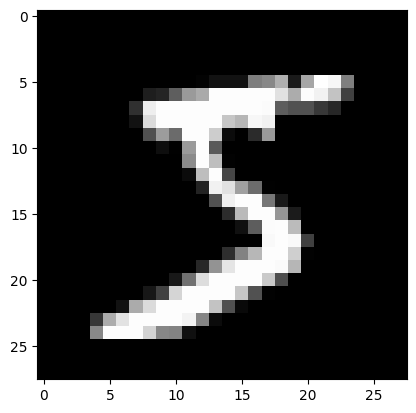

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## 목록/사전 입력 또는 중첩 입력이 있는 RNN

중첩 구조를 통해 실행자는 단일 타임스텝 내에 더 많은 정보를 포함할 수 있습니다. 예를 들어, 비디오 프레임에는 오디오 및 비디오 입력이 동시에 있을 수 있습니다. 이 경우의 데이터 형상은 다음과 같습니다.

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

또 다른 예로, 필기 데이터는 펜의 압력 정보뿐만 아니라 현재 위치에 대한 좌표 x 및 y를 모두 가질 수 있습니다. 따라서 데이터 표현은 다음과 같습니다.

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

다음 코드는 이러한 구조화된 입력을 허용하는 사용자 정의 RNN 셀을 빌드하는 방법의 예를 보여줍니다.

### 중첩된 입력/출력을 지원하는 사용자 정의 셀 정의하기

고유한 레이어를 작성하기 위한 자세한 내용은 [하위 클래화를 통해 새로운 레이어 및 모델 만들기](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)를 참조하세요.

In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### 중첩된 입력/출력으로 RNN 모델 구축

`keras.layers.RNN` 레이어와 방금 정의한 사용자 정의 셀을 이용하는 Keras 모델을 빌드해 보겠습니다.

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### 무작위로 생성된 데이터로 모델 훈련

이 모델에는 적합한 후보 데이터세트가 없기 때문에 임의의 Numpy 데이터를 데모용으로 사용합니다.

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

 1/10 [==>...........................] - ETA: 9s - loss: 1.2420 - rnn_1_loss: 0.3297 - rnn_1_1_loss: 0.9122 - rnn_1_accuracy: 0.0938 - rnn_1_1_accuracy: 0.0273

 4/10 [===========>..................] - ETA: 0s - loss: 0.9184 - rnn_1_loss: 0.3088 - rnn_1_1_loss: 0.6096 - rnn_1_accuracy: 0.1211 - rnn_1_1_accuracy: 0.0365

 7/10 [====================>.........] - ETA: 0s - loss: 0.8233 - rnn_1_loss: 0.2865 - rnn_1_1_loss: 0.5369 - rnn_1_accuracy: 0.1183 - rnn_1_1_accuracy: 0.0352

10/10 [==============================] - ETA: 0s - loss: 0.7488 - rnn_1_loss: 0.2669 - rnn_1_1_loss: 0.4819 - rnn_1_accuracy: 0.1047 - rnn_1_1_accuracy: 0.0352

10/10 [==============================] - 1s 20ms/step - loss: 0.7488 - rnn_1_loss: 0.2669 - rnn_1_1_loss: 0.4819 - rnn_1_accuracy: 0.1047 - rnn_1_1_accuracy: 0.0352


Keras `keras.layers.RNN` 레이어를 사용하면 시퀀스 내 개별 스텝에 대한 수학적 논리만 정의하면 되며 시퀀스 반복은 `keras.layers.RNN` 레이어가 처리해 줍니다. 새로운 형태의 RNN(예: LSTM 변형) 프로토타입을 빠르게 시도해볼 수 있는 매우 강력한 방법입니다.

자세한 내용은 [API 설명서](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/)를 참조하세요.